In [ ]:
!nvidia-smi

Mon Jul 12 15:22:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P0    35W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Run to get files

In [ ]:
import time
!mkdir data

In [ ]:
#True if you want training data
if True:
    start = time.time()
    print('downloading training data...')
    !wget -q http://images.cocodataset.org/zips/train2017.zip 
    print('unziping training data...')
    !unzip -q train2017.zip -d data/images
    print('Training Data Done in ', (time.time() - start)/60.0)
    !rm '/content/train2017.zip'

downloading training data...
unziping training data...
Training Data Done in  24.23659894069036


In [ ]:
#True if you want val data
if True:
    start = time.time()
    print('downloading validation data...')
    !wget -q http://images.cocodataset.org/zips/val2017.zip 
    print('unziping validation data...')
    !unzip -q val2017.zip -d data/images
    print('Validation Data Done in ', (time.time() - start)/60.0)
    !rm '/content/val2017.zip'

downloading validation data...
unziping validation data...
Validation Data Done in  0.9313145558039347


In [ ]:
#True if you want test data
if False:
    start = time.time() 
    print('Downloading test data...')
    !wget -q http://images.cocodataset.org/zips/test2017.zip
    print('Unziping test data...')
    !unzip -q test2017.zip -d data/images
    print('Testing Data Done in ', (time.time() - start)/60.0)

In [ ]:
#True if you want Annotations
if True:
    start = time.time()
    print('Annotations Starting...')
    !wget -q http://images.cocodataset.org/annotations/annotations_trainval2017.zip
    print('Unziping annotations data...')
    !unzip -q annotations_trainval2017.zip -d data
    print('Annotations Done in ', (time.time() - start)/60.0)

Annotations Starting...
Unziping annotations data...
Annotations Done in  0.39482888380686443


# Setting up environment

In [ ]:
!pip -q install pycoco

In [ ]:
!pip -q install pycocotools

In [ ]:
!pip -q install --upgrade mxnet gluoncv

In [ ]:
!pip -q install imgaug

In [ ]:
import json
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import skimage.io as io
import random
import os
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pycocotools.coco import COCO
import pickle
from gluoncv import data as gloun_data
from gluoncv import utils as gloun_utils
import copy
import inspect
import imgaug as ia
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import tensorflow as tf

#for visualizing the outputs
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.8.0` and `torch==1.9.0+cu102` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


# Helper Functions

In [ ]:
def show(img, p1 = None, p2 = None, bb = None, to_normalize = False):
    if p1 == None and bb == None and to_normalize == True:
        img = np.multiply(img,255.0)
        cv2_imshow(img)
        
    elif not to_normalize:
        cv2.rectangle(img, p1, p2, color = (255, 0, 0), thickness = 1)
        cv2_imshow(img)
    else:
        img = np.multiply(img,255.0)
        bb = np.around(bb * img.shape[0], decimals=0)
        bb = bb.astype(np.int32)
        bb = tuple(bb)
        p1, p2 = bb[0:2], bb[2:]
        cv2.rectangle(img, p1, p2, color = (255, 0, 0), thickness = 1)
        cv2_imshow(img)

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id'] == classID:
            return cats[i]['name']
    return "None"

In [ ]:
def show_img(img_id):
    img = coco.loadImgs(ids = img_id)[0]
    img_name =  img['file_name']
    I = io.imread(f'{dataDir}/images/{dataType}/{img_name}')/255.0

    plt.axis('off')
    plt.imshow(I)
    plt.show()

In [ ]:
def getAnns(img_id, draw_bbox = True ,to_show = False):
    img = coco.loadImgs(ids = img_id)[0]
    annsIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annsIds)

    if not to_show: 
        return anns
    elif not draw_bbox:
        img_name =  img['file_name']
        I = io.imread(f'{dataDir}/{dataType}/{img_name}')/255.0
        plt.imshow(I)
        plt.axis('off')
        coco.showAnns(anns)
        return anns
    elif draw_bbox:
        img_name =  img['file_name']
        I = io.imread(f'{dataDir}/{dataType}/{img_name}')/255.0
        plt.imshow(I)
        plt.axis('off')
        coco.showAnns(anns, draw_bbox=True)
        return anns

In [ ]:
def getImage(imageObj, img_folder, input_image_size):
    train_img = io.imread(img_folder + '/' + imageObj['file_name'])/255.0
    train_img = cv2.resize(train_img, input_image_size)
    if len(train_img.shape) == 3 and train_img.shape[2] == 3:
        return train_img
    else:
        stacked_img = np.stack((train_img,)*3, axis = -1)
        return stacked_img

In [ ]:
def getNormalMask(imageObj, classes, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className) + 1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_image_size)
        train_mask = np.maximum(new_mask, train_mask)
    
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

In [ ]:
def getBinaryMask(imageObj, coco, catIds, input_image_size):
    annIds = coco.getAnnIds(imageObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    train_mask = np.zeros(input_image_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_image_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_image_size[0], input_image_size[1], 1)
    return train_mask

In [ ]:
def getBbox(imageObj, coco, catIds):
    #catIds contains all classes and ids
    annIds = coco.getAnnIds(imageObj['id'], catIds = catIds, iscrowd = None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    bboxes = {}
    for a in range(len(anns)):
        bbox = anns[a]['bbox']
        bbox_class_id = anns[a]['category_id']
        try: bboxes[bbox_class_id].append(bbox)
        except: bboxes[bbox_class_id] = [bbox]
    return bboxes

In [ ]:
def normalize_bb(bb, h, w):
    x1, x2 = bb[0]/w, bb[2]/w
    y1, y2 = bb[1]/h, bb[3]/h
    return [x1, y1, x2, y2]
    
def normalize_bbs(bounding_boxes, h, w):
    for i in range(len(bounding_boxes)):
        bb = bounding_boxes[i]
        x1, x2 = bb[0]/w, bb[2]/w
        y1, y2 = bb[1]/h, bb[3]/h
        bounding_boxes[i] = x1, y1, x2, y2
    return bounding_boxes

In [ ]:
def resize_bb(bounding_boxes, h, w, IMAGE_H =  416, IMAGE_W = 416):
    x1, x2 = (bounding_boxes[:, 0]/w) * IMAGE_W, (bounding_boxes[:, 2]/w) * IMAGE_W
    y1, y2 = (bounding_boxes[:, 1]/h) * IMAGE_H, (bounding_boxes[:, 3]/h) * IMAGE_H
    bbs = []
    for i in range(len(bounding_boxes)):
        bbs.append([x1[i], y1[i], x2[i], y2[i]])
    return np.array(bbs)

# Using glouncv, making training and validation datasets  

In [ ]:
!mv '/content/data/images/train2017' '/content/data'
!mv '/content/data/images/val2017' '/content/data'

mv: cannot stat '/content/data/images/train2017': No such file or directory
mv: cannot stat '/content/data/images/val2017': No such file or directory


## for all classes

In [ ]:
dataDir = '/content/data'
train_dataset = gloun_data.COCODetection(dataDir, splits = ['instances_train2017'])
val_dataset = gloun_data.COCODetection(dataDir, splits = ['instances_val2017'])
print('Num of training images:', len(train_dataset))
print('Num of val images:', len(val_dataset))

loading annotations into memory...
Done (t=25.36s)
creating index...
index created!
loading annotations into memory...
Done (t=0.73s)
creating index...
index created!
Num of training images: 117266
Num of val images: 4952


In [ ]:
train_image, train_label = train_dataset[100000]

In [ ]:
bounding_boxes = train_label[:,:4]
class_ids = train_label[:,4:5]

In [ ]:
train_image.shape

(480, 640, 3)

In [ ]:
bounding_boxes.shape

(14, 4)

In [ ]:
bounding_boxes

array([[205.44, 200.84, 321.02, 277.73],
       [202.89, 107.88, 325.6 , 193.97],
       [330.25, 120.99, 441.31, 189.41],
       [325.85, 201.33, 437.21, 276.79],
       [  1.03, 319.76, 177.84, 473.96],
       [113.26, 178.25, 239.54, 474.96],
       [416.36, 174.41, 529.7 , 472.2 ],
       [350.71, 211.07, 417.22, 263.47],
       [426.58, 294.84, 447.88, 304.32],
       [394.26, 324.36, 415.47, 336.39],
       [  1.25, 315.05, 174.79, 471.15],
       [564.62, 298.78, 638.85, 476.77],
       [226.92, 212.31, 303.94, 256.86],
       [605.57, 193.48, 632.82, 229.53]])

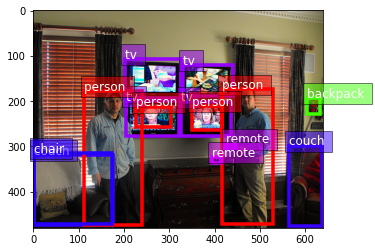

In [ ]:
gloun_utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores = None, labels = class_ids, class_names = train_dataset.classes)

In [ ]:
with open('train_dataset.pkl', 'wb') as output:
    pickle.dump(train_dataset, output, protocol=pickle.HIGHEST_PROTOCOL)
with open('val_dataset.pkl', 'wb') as output:
    pickle.dump(val_dataset, output, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp train_dataset.pkl '/content/drive/My Drive/Colab Notebooks/Object Detection'
!cp val_dataset.pkl '/content/drive/My Drive/Colab Notebooks/Object Detection'

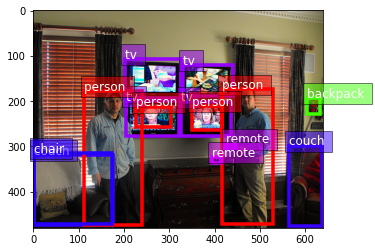

In [ ]:
train_image, train_label = train_dataset[100000]
bounding_boxes = train_label[:,:4]
class_ids = train_label[:,4:5]
gloun_utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores = None, labels = class_ids, class_names = train_dataset.classes)

In [ ]:
type(train_dataset)

gluoncv.data.mscoco.detection.COCODetection

## using glouncv to make training and validation dataset for only some classes

In [ ]:
#wanted_class_ids = 1,2,3,5
wanted_class_ids = 62, 63, 64, 65, 67, 70

In [ ]:
t = True
v = True
if v:
    dataType = 'val2017'
    annFile = f'{dataDir}/annotations/instances_{dataType}.json'
if t:
    dataType = 'train2017'
    annFile = f'{dataDir}/annotations/instances_{dataType}.json'

coco = COCO(annFile)

catIds = coco.getCatIds()
cats = coco.loadCats(catIds)
all_classes = [i['name'] for i in cats]

for i in wanted_class_ids:
    print(getClassName(i+1, cats))

loading annotations into memory...
Done (t=23.90s)
creating index...
index created!
couch
potted plant
bed
None
None
None


In [ ]:
train_image_instances_idxes = [] 
for i in tqdm(range(len(train_dataset))):
    train_label = train_dataset[i][1]
    class_ids = train_label[:, 4:5]
    for id in class_ids:
        if id in wanted_class_ids and i not in train_image_instances_idxes:
            train_image_instances_idxes.append(i)

100%|██████████| 117266/117266 [08:19<00:00, 234.76it/s]


In [ ]:
len(train_image_instances_idxes)

12942

In [ ]:
with open('train_image_instances_idxes_furniture.pkl', 'wb') as output:
    pickle.dump(train_image_instances_idxes, output, protocol=pickle.HIGHEST_PROTOCOL)
!cp train_image_instances_idxes_furniture.pkl '/content/drive/My Drive/Colab Notebooks/Object Detection'

In [ ]:
val_image_instances_idxes = [] 
for i in tqdm(range(len(val_dataset))):
    val_label = val_dataset[i][1]
    class_ids = val_label[:, 4:5]
    for id in class_ids:
        if id in wanted_class_ids and i not in val_image_instances_idxes:
            val_image_instances_idxes.append(i)

100%|██████████| 4952/4952 [00:14<00:00, 345.58it/s]


In [ ]:
val_image_instances_idxes.sort()
len(val_image_instances_idxes)

595

In [ ]:
train_image_instances_idxes = list(set(train_image_instances_idxes))
train_image_instances_idxes.sort()

In [ ]:
with open('val_image_instances_idxes_furniture.pkl', 'wb') as output:
    pickle.dump(val_image_instances_idxes, output, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp val_image_instances_idxes_furniture.pkl '/content/drive/My Drive/Colab Notebooks/Object Detection'

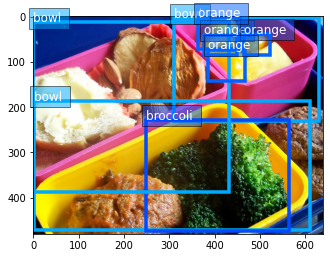

In [ ]:
train_image, train_label = train_dataset[0]
bounding_boxes = train_label[:,:4]
class_ids = train_label[:,4:5]
gloun_utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores = None, labels = class_ids, class_names = train_dataset.classes)

In [ ]:
print(train_label)

[[  1.08 187.69 611.67 472.53  45.  ]
 [311.73   4.31 630.01 231.99  45.  ]
 [249.6  229.27 564.84 473.35  50.  ]
 [  0.    13.51 433.48 387.63  45.  ]
 [376.2   40.36 450.75  85.89  49.  ]
 [465.78  38.97 522.85  84.64  49.  ]
 [385.7   73.66 468.72 143.17  49.  ]
 [364.05   2.49 457.81  72.56  49.  ]]


In [ ]:
getClassName(4, cats)

'motorcycle'

In [ ]:
val_image_instances_idxes[:5]

[0, 10, 11, 15, 41]

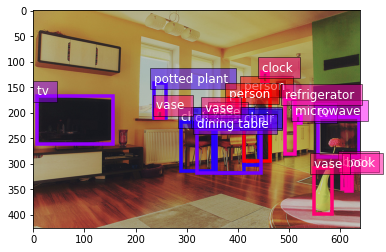

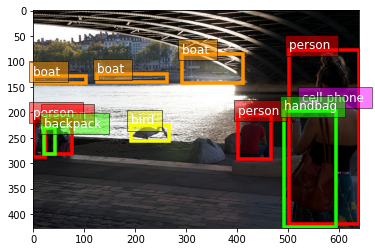

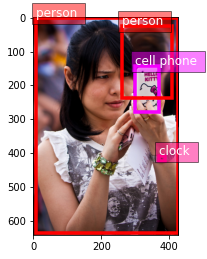

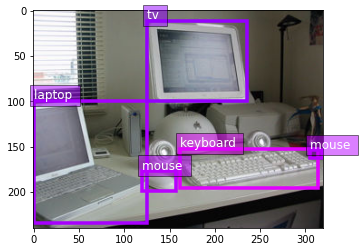

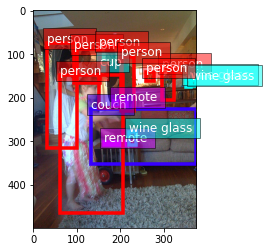

In [ ]:
for i in val_image_instances_idxes[:5]:
    val_image, val_label = val_dataset[i]
    bounding_boxes = val_label[:,:4]
    class_ids = val_label[:,4:5]
    gloun_utils.viz.plot_bbox(val_image.asnumpy(), bounding_boxes, scores = None, labels = class_ids, class_names = train_dataset.classes)

# Working with data

In [ ]:
t = True
v = True
dataDir = '/content/data'
if v:
    dataType = 'val2017'
    annFile = f'{dataDir}/annotations/instances_{dataType}.json'
if t:
    dataType = 'train2017'
    annFile = f'{dataDir}/annotations/instances_{dataType}.json'

coco = COCO(annFile)

loading annotations into memory...
Done (t=19.69s)
creating index...
index created!


In [ ]:
catIds = coco.getCatIds()
cats = coco.loadCats(catIds)
all_classes = [i['name'] for i in cats]

In [ ]:
!mv '/content/data/images/train2017' '/content/data'
!mv '/content/data/images/val2017' '/content/data'
import_dataset = True
if import_dataset:
    #True if you want all data
    with open('/content/drive/My Drive/Colab Notebooks/Object Detection/train_dataset.pkl', 'rb') as input:
        train_dataset = pickle.load(input)
    with open('/content/drive/My Drive/Colab Notebooks/Object Detection/val_dataset.pkl', 'rb') as input:
        val_dataset = pickle.load(input)
if import_dataset:
    #True if you want only particular classes
    pass

mv: cannot stat '/content/data/images/train2017': No such file or directory
mv: cannot stat '/content/data/images/val2017': No such file or directory


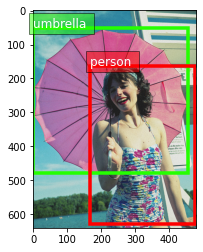

In [ ]:
if import_dataset:
    train_image, train_label = train_dataset[4]
    bounding_boxes = train_label[:,:4]
    class_ids = train_label[:,4:5]
    gloun_utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores = None, labels = class_ids, class_names = train_dataset.classes)

In [ ]:
unit_testing = True

In [ ]:
len(all_classes)

80

In [ ]:
#wanted_class_ids = 1,2,3,5
wanted_class_ids = 62, 63, 64, 65, 67, 70
if wanted_class_ids == len(all_classes):
    labels = all_classes
else:
    labels = []
    for i in wanted_class_ids:
        labels.append(getClassName(i, cats))
    print(labels)

['chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet']


In [ ]:
if import_dataset:
    with open('/content/drive/My Drive/Colab Notebooks/Object Detection/train_image_instances_idxes_furniture.pkl' , mode = 'rb') as input:
        train_image_instances_idxes = pickle.load(input)
    with open('/content/drive/My Drive/Colab Notebooks/Object Detection/val_image_instances_idxes_furniture.pkl', mode = 'rb') as input:
        val_image_instances_idxes = pickle.load(input)
    with open('/content/drive/My Drive/Colab Notebooks/Object Detection/kmeans_results_furniture.pkl', mode = 'rb') as input:
        results = pickle.load(input)  

# Exploring Data

In [ ]:
dataDir = '/content/data'
dataType = 'val2017'
annFile = f'{dataDir}/annotations/instances_{dataType}.json'

coco = COCO(annFile)
#load categories in a variable
catIds = coco.getCatIds()
cats = coco.loadCats(catIds)
#categories

loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


Trying out class filtering

In [ ]:
cats

[{'id': 1, 'name': 'person', 'supercategory': 'person'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'vehicle'},
 {'id': 3, 'name': 'car', 'supercategory': 'vehicle'},
 {'id': 4, 'name': 'motorcycle', 'supercategory': 'vehicle'},
 {'id': 5, 'name': 'airplane', 'supercategory': 'vehicle'},
 {'id': 6, 'name': 'bus', 'supercategory': 'vehicle'},
 {'id': 7, 'name': 'train', 'supercategory': 'vehicle'},
 {'id': 8, 'name': 'truck', 'supercategory': 'vehicle'},
 {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'},
 {'id': 10, 'name': 'traffic light', 'supercategory': 'outdoor'},
 {'id': 11, 'name': 'fire hydrant', 'supercategory': 'outdoor'},
 {'id': 13, 'name': 'stop sign', 'supercategory': 'outdoor'},
 {'id': 14, 'name': 'parking meter', 'supercategory': 'outdoor'},
 {'id': 15, 'name': 'bench', 'supercategory': 'outdoor'},
 {'id': 16, 'name': 'bird', 'supercategory': 'animal'},
 {'id': 17, 'name': 'cat', 'supercategory': 'animal'},
 {'id': 18, 'name': 'dog', 'supercategory': 'animal'},

In [ ]:
all_classes

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [ ]:
if False:
    temp = getAnns(images[0]['id'], True, to_show=True)
    print(getClassName(1, cats), getClassName(40, cats))
    getBbox(images[0], coco, catIds)

In [ ]:
for i in inspect.getmembers(train_dataset): 
      
    # to remove private and protected 
    # functions 
    if not i[0].startswith('_'): 
          
        # To remove other methods that 
        # doesnot start with a underscore 
        if not inspect.ismethod(i[1]):  
            print(i) 

('CLASSES', ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'])
('annotation_dir', 'annotations')
('classes', ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck',

In [ ]:
type(bounding_boxes)

numpy.ndarray

(416, 416, 3)
[[0.0, 32.577999999999996, 394.96648648648653, 311.6555], [144.93405405405406, 105.87849999999999, 412.70486486486493, 407.6019999999999]]


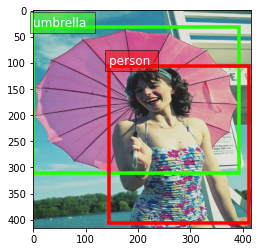

In [ ]:
h, w, c = train_image.shape

image = cv2.resize(train_image.asnumpy(), (416,416))
print(image.shape)

x1, x2 = (bounding_boxes[:, 0]/w) * 416, (bounding_boxes[:, 2]/w) * 416
y1, y2 = (bounding_boxes[:, 1]/h) * 416, (bounding_boxes[:, 3]/h) * 416
bbs = []
for i in range(len(bounding_boxes)):
    bbs.append([x1[i], y1[i], x2[i], y2[i]])

print(bbs)

gloun_utils.viz.plot_bbox(image, bbs, scores = None, labels = class_ids, class_names = train_dataset.classes)

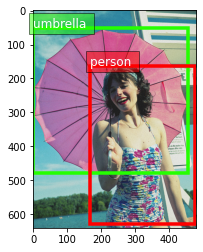

In [ ]:
gloun_utils.viz.plot_bbox(train_image.asnumpy(), bounding_boxes, scores = None, labels = class_ids, class_names = train_dataset.classes)

# Data Generator

In [ ]:
def filterDataset(folder, classes = None, mode = 'train2017'):
    
    #initialize COCO api for instance annotations
    annFile = f'{folder}/annotations/instances_{mode}.json'
    coco = COCO(annFile)

    images = []
    if classes != None:
        for className in classes:
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)

    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)
    
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
        
    random.shuffle(unique_images)
    dataset_size = len(unique_images)

    return unique_images, dataset_size, coco

#images, dataset_size, coco = filterDataset(dataDir, classes=all_classes, mode = 'val2017')

In [ ]:
def dataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4,
                      mode='train', mask_type='binary'):
    
    img_folder = f'{folder}/images/{mode}'
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0
    while True:
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_image_size[0], input_image_size[1], 1)).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

In [ ]:
def BBoxdataGeneratorCoco(images, classes, coco, folder, 
                      input_image_size=(224,224), batch_size=4,
                      mode='train', mask_type='binary'):
    
    img_folder = f'{folder}/images/{mode}'
    dataset_size = len(images)
    catIds = coco.getCatIds(catNms=classes)
    
    c = 0

    while True:
        img = np.zeros((batch_size, input_image_size[0], input_image_size[1], 3)).astype('float')
        bboxes = np.zeros((batch_size, 1, 4, len(classes))).astype('float')

        for i in range(c, c+batch_size): #initially from 0 to batch_size, when c = 0
            imageObj = images[i]
            
            ### Retrieve Image ###
            train_img = getImage(imageObj, img_folder, input_image_size)
            
            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imageObj, coco, catIds, input_image_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imageObj, classes, coco, catIds, input_image_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(images)
        yield img, mask

# K-means Clustering to find best anchor box sizes



k = 6(For all classes): anchors = 
    array([[0.16229321, 0.3852111],  
        [0.40331376, 0.22255976],  
        [0.36997938, 0.61552492],  
        [0.80217983, 0.7248515 ],  
        [0.03442823, 0.05350549],  
        [0.10920654, 0.1449014 ]])  

k = 4(for 4 classes): anchors =   
    array([[0.27600873, 0.41786165],  
        [0.03311251, 0.05311582],  
        [0.69056061, 0.62672003],  
        [0.11495971, 0.17188359]])

In [ ]:
n = 2000

d = {}
for id in wanted_class_ids:
    d[id] = 0

if True:
    all_bounding_boxes = []
    for i in tqdm(train_image_instances_idxes):
        train_image, train_label = train_dataset[i]
        h, w, _ = train_image.shape
        bounding_boxes = train_label[:,:4]
        class_ids = train_label[:, 4]
        for i, id in enumerate(class_ids):
            if id in wanted_class_ids and d[id] < n:
                bb = normalize_bb(bounding_boxes[i], h, w)
                all_bounding_boxes.append(bb)
                d[id] += 1

In [ ]:
len(all_bounding_boxes)

In [ ]:
all_bounding_boxes[:5]

In [ ]:
d[62]

In [ ]:
with open('bounding_boxes_for_wanted_ids_furniture.pkl', 'wb') as output:
    pickle.dump(all_bounding_boxes, output, protocol=pickle.HIGHEST_PROTOCOL)
!cp bounding_boxes_for_wanted_ids_furniture.pkl '/content/drive/My Drive/Colab Notebooks/Object Detection'

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Object Detection/bounding_boxes_for_wanted_ids_furniture.pkl', 'rb') as input:
    all_bounding_boxes = pickle.load(input)

In [ ]:
all_bounding_boxes[0]

In [ ]:
def get_wh(bb):
    w = bb[2] - bb[0]
    h = bb[3] - bb[1]
    return w, h

In [ ]:
def iou(box, clusters):
    """
    Calculates the Intersection over Union (IoU) between a box and k clusters.
    params:
        box: tuple or array, shifted to the origin (i. e. width and height)
        clusters: numpy array of shape (k, 2) where k is the number of clusters
    returns: numpy array of shape (k, 0) where k is the number of clusters
    """

    x = np.minimum(clusters[:, 0], box[0])
    y = np.minimum(clusters[:, 1], box[1])

    intersection = x * y
    box_area = box[0] * box[1]
    cluster_area = clusters[:, 0] * clusters[:, 1]

    iou_ = intersection / (box_area + cluster_area - intersection)
     
    return iou_

In [ ]:
boxes = [get_wh(bb) for bb in all_bounding_boxes]
boxes = np.array(boxes)

In [ ]:
c = boxes[np.random.choice(boxes.shape[0], 3, replace = False)]
b = boxes[0]
print(c[:, 0])
print(b[0])
np.minimum(c[:, 0], b[0])

In [ ]:
print(c)
print(b)

In [ ]:
def kmeans(boxes, k, dist = np.median):
    """
    Calculates k-means clustering with the IOU metric
    param:
        boxes : numpy array of shape(r, 2), where r is the number of rows
        k: number of clusters
        dist : distance function
    return: numpy array of shape (k, 2)
    """
    np.random.seed(1)

    rows = boxes.shape[0]
    distances = np.empty((rows, k))
    last_clusters = np.zeros((rows, ))
    
    #initialize the clusters
    clusters = boxes[np.random.choice(rows, k, replace = False)]

    while True:
        # Step 1: allocate each item to closest cluster centers
        for icluster in range(k):
            distances[:, icluster] = 1 - iou(clusters[icluster], boxes) 
    
        nearest_clusters = np.argmin(distances, axis = 1)

        if (last_clusters == nearest_clusters).all():
            break
        
        for cluster in range(k):
            clusters[cluster] = dist(boxes[nearest_clusters == cluster], axis = 0)
        
        last_clusters = nearest_clusters

    return clusters, nearest_clusters, distances


In [ ]:
kmax = 11
dist = np.mean
results = {}
for k in range(2, kmax):
    clusters, nearest_clusters, distances = kmeans(boxes, k, dist)
    WithinClusterMeanDist = np.mean(distances[np.arange(distances.shape[0]), nearest_clusters])
    result = {
                'clusters' : clusters,
                'nearest_clusters' : nearest_clusters,
                'distances' : distances,
                'WithinClusterMeanDist' : WithinClusterMeanDist
                }
    
    print("{:2.0f} clusters: mean IoU = {:5.4f}".format(k, 1-result['WithinClusterMeanDist']))
    results[k] = result

In [ ]:
def plot_cluster_result(plt, clusters, nearest_clusters, WithinClusterSumDist, wh):
    for icluster in np.unique(nearest_clusters):
        pick = nearest_clusters==icluster
        c = current_palette[icluster]
        plt.rc('font', size=8) 
        plt.plot(wh[pick,0],wh[pick,1],"p",
                 color=c,
                 alpha=0.5,label="cluster = {}, N = {:6.0f}".format(icluster,np.sum(pick)))
        plt.text(clusters[icluster,0],
                 clusters[icluster,1],
                 "c{}".format(icluster),
                 fontsize=20,color="red")
        plt.title("Clusters")
        plt.xlabel("width")
        plt.ylabel("height")
    plt.legend(title="Mean IoU = {:5.4f}".format(WithinClusterSumDist))  
    
import seaborn as sns
current_palette = list(sns.xkcd_rgb.values())

figsize = (15,35)
count =1 
fig = plt.figure(figsize=figsize)
for k in range(2,kmax):
    result = results[k]
    clusters = result["clusters"]
    nearest_clusters = result["nearest_clusters"]
    WithinClusterSumDist = result["WithinClusterMeanDist"]
    
    ax = fig.add_subplot(kmax/2,2,count)
    plot_cluster_result(plt,clusters,nearest_clusters,1 - WithinClusterSumDist,boxes)
    count += 1
plt.show()

In [ ]:
plt.figure(figsize=(6,6))
plt.plot(np.arange(2,kmax),
         [1 - results[k]["WithinClusterMeanDist"] for k in range(2,kmax)],"o-")
plt.title("within cluster mean of {}".format(dist))
plt.ylabel("mean IOU")
plt.xlabel("N clusters (= N anchor boxes)")
plt.show()

In [ ]:
results[10]

In [ ]:
with open('kmeans_results_furniture.pkl', mode = 'wb') as output:
    pickle.dump(results, output, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
!cp kmeans_results_furniture.pkl '/content/drive/My Drive/Colab Notebooks/Object Detection'

# Input Output encoding

In [ ]:
anchors = np.array([
        [0.73461366, 0.49909597],
        [0.44650982, 0.62718849],
        [0.0878548 , 0.1084984 ],
        [0.24693894, 0.41795113],
        [0.45528903, 0.28017739],
        [0.23261409, 0.15311639],
        [0.12770871, 0.26431176],
        [0.81126535, 0.82476636],
        [0.03583341, 0.04242817]
        ])

In [ ]:
k = 10
# The k anchor boxes i am going to use are: [w,h]
anchors = np.array([
        [0.21370442, 0.1641513 ],
        [0.27514174, 0.28946566],
        [0.55584405, 0.33304142],
        [0.03054996, 0.0286856 ],
        [0.12135486, 0.31179675],
        [0.10618365, 0.12779786],
        [0.82725483, 0.79624848],
        [0.07317357, 0.06382683],
        [0.52261999, 0.68014612],
        [0.3225101 , 0.51351479]
        ])
anchors_original = anchors.copy()
config = {"IMAGE_W":416,
          "IMAGE_H":416,
          "GRID_W":13,
          "GRID_H":13,
          'BOX':k,
          "LABELS": labels,
          "ANCHORS": anchors,
          "BATCH_SIZE":4,
          "TRUE_BOX_BUFFER":50,
          "LAMBDA_COORD": 1.0,
          "LAMBDA_NO_OBJECT":1.0,
          'LAMBDA_OBJECT':5.0,
          'LAMBDA_CLASS':1.0,
          'WANTED_CLASS_IDS': wanted_class_ids
          }
# rescaling anchors to grid scale
anchors[:, 0], anchors[:, 1] = anchors[:, 0] * config['GRID_W'], anchors[:, 1] * config['GRID_H']


## Input

In [ ]:
def normalize_img(image):
    return image/255.

In [ ]:
class ImageReader(object):
    def __init__(self, IMAGE_H, IMAGE_W, norm = None):
        """
        IMAGE_H, IMAGE_W is the height and width of the resized image
        """
        self.IMAGE_H = IMAGE_H
        self.IMAGE_W = IMAGE_W
        self.norm = norm
    
    def encode_core(self, image, reorder_rgb = True):
        #rescale the image to standard size
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))
        if reorder_rgb:
            image = image[:, :, ::-1]
        if self.norm is not None:
            image = self.norm(image)
        return (image)

    def fit(self, train_instance):
        '''
        read in and resize the image, annotations are resized accordingly.
        -- Input -- 
        train_instance : a tuple containing train_image and train_label
        
        '''
        image = train_instance[0].asnumpy()
        h, w, c = image.shape
        image = self.encode_core(image, reorder_rgb=False)
        
        label = train_instance[1]
        bounding_boxes = []
        class_ids = label[:,4:5]
        final_ids = []
        
        for i, id in enumerate(class_ids):
            if id in wanted_class_ids:
                bounding_boxes.append(label[i, :4])
                final_ids.append(id)

        bounding_boxes = np.asarray(bounding_boxes)
        final_ids = np.asarray(final_ids)
        bounding_boxes = resize_bb(bounding_boxes, h, w, self.IMAGE_H, self.IMAGE_W)

        return image, bounding_boxes, final_ids

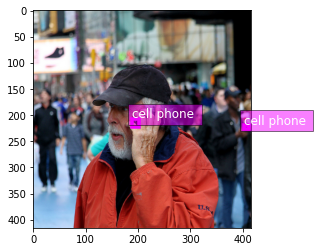

In [ ]:
imagereader = ImageReader(416,416, norm = None)
image, bounding_boxes, class_ids = imagereader.fit(train_dataset[train_image_instances_idxes[4]])
gloun_utils.viz.plot_bbox(image, bounding_boxes, labels=class_ids, class_names = train_dataset.classes)

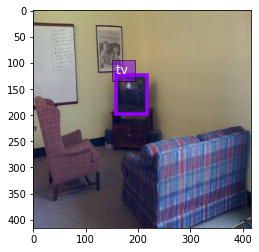

In [ ]:
imagereader = ImageReader(416,416, norm = None)
image, bounding_boxes, class_ids = imagereader.fit(val_dataset[val_image_instances_idxes[5]])
gloun_utils.viz.plot_bbox(image, bounding_boxes, labels=class_ids, class_names = train_dataset.classes)

## Output

### Visualizing selected Anchor boxes

In [ ]:
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw

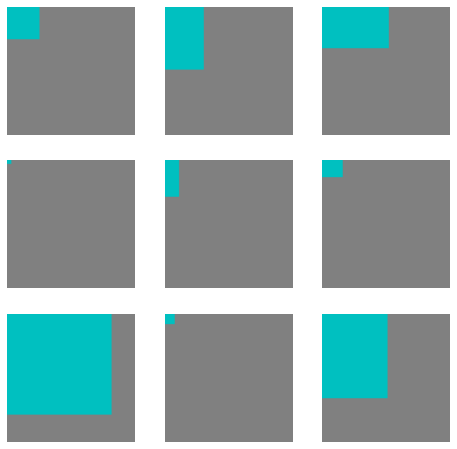

In [ ]:
anchors_original = results[9]['clusters']
fig = plt.figure(figsize=(8,8))
columns = 3
rows = 3
for i in range(1, 9+1):
    im = Image.new('RGB', (1000, 1000), (128, 128, 128))
    draw = ImageDraw.Draw(im)
    draw.rectangle((0, 0, int(anchors_original[i-1][0] * 1000), int(anchors_original[i-1][1] * 1000)), fill=(0, 192, 192))
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    plt.imshow(im)
plt.show()

### Finding best anchor box for given candidate anchor boxes


In [ ]:
class BoundBox(object):
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None,classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax
        ## the code below are used during inference
        # probability
        self.confidence = confidence
        # class probaiblities [c1, c2, .. cNclass]
        self.set_class(classes)
        
    def set_class(self,classes):
        self.classes = classes
        self.label = np.argmax(self.classes) 
        
    def get_label(self):  
        return self.label
    
    def get_score(self):
        return self.classes[self.label]

In [ ]:
class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        '''
        ANCHORS: a np.array of shape (k, 2) where every row is an individual anchor

        '''
        self.anchors = [BoundBox(0, 0, ANCHORS[i][0], ANCHORS[i][1]) 
                        for i in range(len(ANCHORS))]
        
    def _interval_overlap(self,interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        if x3 < x1:
            if x4 < x1:
                return 0
            else:
                return min(x2,x4) - x1
        else:
            if x2 < x3:
                 return 0
            else:
                return min(x2,x4) - x3  

    def bbox_iou(self,box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
        intersect_h = self._interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  

        intersect = intersect_w * intersect_h

        w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
        w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin

        union = w1*h1 + w2*h2 - intersect

        return float(intersect) / union
    
    def find(self,center_w, center_h):
        # find the anchor that best predicts this box
        best_anchor = -1
        max_iou = -1
        # each Anchor box is specialized to have a certain shape.
        # e.g., flat large rectangle, or small square
        shifted_box = BoundBox(0, 0,center_w, center_h)
        ##  For given object, find the best anchor box!
        for i in range(len(self.anchors)): ## run through each anchor box
            anchor = self.anchors[i]
            iou = self.bbox_iou(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou = iou
        return best_anchor, max_iou    

In [ ]:
# Unit testing
if True:
    print(f"Allocating bounding boxes of various width and height into the {k} categories")
    babf = BestAnchorBoxFinder(anchors_original)
    for w in range(1, 9, 2):
        w/=10.
        for h in range(1,9,2):
            h/=10.
            best_anchor, max_iou = babf.find(w, h)
            print(f"bounding box (w = {w}, h = {h}) --> best anchor box index = {best_anchor}, iou = {max_iou}")

Allocating bounding boxes of various width and height into the 10 categories
bounding box (w = 0.1, h = 0.1) --> best anchor box index = 7, iou = 0.5901122439652304
bounding box (w = 0.1, h = 0.3) --> best anchor box index = 4, iou = 0.8766658206521135
bounding box (w = 0.1, h = 0.5) --> best anchor box index = 4, iou = 0.5440029614498746
bounding box (w = 0.1, h = 0.7) --> best anchor box index = 4, iou = 0.3943583002547098
bounding box (w = 0.3, h = 0.1) --> best anchor box index = 5, iou = 0.45640453359855165
bounding box (w = 0.3, h = 0.3) --> best anchor box index = 0, iou = 0.7088270308049002
bounding box (w = 0.3, h = 0.5) --> best anchor box index = 1, iou = 0.9703590885138647
bounding box (w = 0.3, h = 0.7) --> best anchor box index = 1, iou = 0.69456035582129
bounding box (w = 0.5, h = 0.1) --> best anchor box index = 2, iou = 0.2983023143047965
bounding box (w = 0.5, h = 0.3) --> best anchor box index = 2, iou = 0.8949069429143895
bounding box (w = 0.5, h = 0.5) --> best anc

### Rescaling anchor boxes to grid scale

In [ ]:
def rescale_centerxy(bb, config):
    """
    config -> dict containing IMAGE_W, IMAGE_H, GRID_W, GRID_H, etc
    """
    center_x = 0.5 * (bb[0] + bb[2])
    center_x = center_x / float(config['IMAGE_W'] / config['GRID_H'])
    center_y = 0.5 * (bb[1] + bb[3])
    center_y = center_y / float(config['IMAGE_H'] / config['GRID_W'])

    return center_x, center_y

In [ ]:
def rescale_centerwh(bb, config):

    center_w = bb[2] - bb[0]
    center_h = bb[3] - bb[1]
    center_w /= float(config['IMAGE_W'] / config['GRID_W'])
    center_h /= float(config['IMAGE_H'] / config['GRID_H'])

    return center_w, center_h

In [ ]:
#unit testing
bb = bounding_boxes[0]
center_x, center_y = rescale_centerxy(bb, config)
center_w, center_h = rescale_centerwh(bb, config)

print(f"center_x = {center_x} range between 0 and {config['GRID_W']}")
print(f"center_y = {center_y} range between 0 and {config['GRID_H']}")
print(f"center_w = {center_w} range between 0 and {config['GRID_W']}")
print(f"center_h = {center_h} range between 0 and {config['GRID_H']}")

center_x = 5.8591 range between 0 and 13
center_y = 5.005346666666667 range between 0 and 13
center_w = 1.8475600000000005 range between 0 and 13
center_h = 2.302213333333333 range between 0 and 13


# Data Augmentation

In [ ]:
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa
import re
import glob

In [ ]:
aug = iaa.SomeOf(3, [
                     iaa.Affine(scale = (0.8, 1.2)),
                     iaa.Affine(rotate = (-15, 15)),
                     iaa.Fliplr(1),
                     #iaa.Multiply((0.8, 1.2)),
                     iaa.GaussianBlur(sigma = (0.5, 1.0))
                     #iaa.AdditiveGaussianNoise(scale = (0.03 * 225, 0.05 * 225))
])

In [ ]:
 def Image_aug(image, bb_array, augmentor):

    #   pass the array of bounding boxes coordinates to the imgaug library
    bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
    image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
    bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
    bbs_aug = bbs_aug.clip_out_of_image()
    bbs_aug = bbs_aug.to_xyxy_array()
    
    return image_aug, bbs_aug

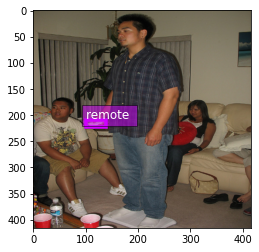

In [ ]:
imagereader = ImageReader(416,416, norm = None)
image, bounding_boxes, class_ids = imagereader.fit(train_dataset[train_image_instances_idxes[0]])
gloun_utils.viz.plot_bbox(image, bounding_boxes, labels=class_ids, class_names = train_dataset.classes)

[[101.48666667 209.105      138.85733333 222.859     ]]
[[276.0729  201.24593 314.35992 217.73096]]


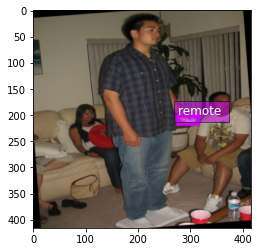

In [ ]:
image_aug, bbs_aug = Image_aug(image, bounding_boxes, aug)
print(bounding_boxes)
print(bbs_aug)
gloun_utils.viz.plot_bbox(image_aug, bbs_aug, labels = class_ids, class_names = train_dataset.classes)

# Keras Batch Generator

### Explaining the output use, shapes, how its arranged, etc

Input Batch: --> x_batch  

    shape = (BATCH_SIZE, IMAGE_H, IMAGE_W, n_channels)


---


Output Batch: --> y_batch

    shape = (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + n_classes)
    box = the number of anchor boxes

    y_batch[i_image, igrid_h, igrid_w, ianchor, :4] contains:
    -> (center_x, center_y, center_w, center_h)

    y_batch[i_image, igrid_h, igrid_w, ianchor, 4] contains:
    -> 1 if the object exist in this (grid cell, anchor) pair, else it contains 0

    y_batch[iframe,igrid_h,igrid_w,ianchor,5 + iclass] contains:
    -> 1 if the iclassth class object exists in this (grid cell, anchor) pair, else it contains 0. 


---

Hack to calculate loss: --> b_batch:

    shape = (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)

    b_batch[i_image,1,1,1,ibuffer,:] contains:
    -> ibufferth object's (center_x,center_y,center_w,center_h) in i_imageth frame

The calculation of the loss function is discussed in detail in  
[Model and loss - by Yumi](https://fairyonice.github.io/Part_3_Object_Detection_with_Yolo_using_VOC_2012_data_model.html)



## Batch generator

In [ ]:
from tensorflow.keras.utils import Sequence

In [ ]:
class SimpleBatchGenerator(Sequence):
    def __init__(self, train_dataset, train_image_instances_idxes, config, norm = None, shuffle = True):
        self.config = config
        self.config["BOX"] = len(self.config['ANCHORS'])
        self.config["CLASS"] = len(self.config['LABELS'])
        self.train_dataset = train_dataset
        self.train_image_instances_idxes = train_image_instances_idxes
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'], config['IMAGE_W'], norm = norm)
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.train_dataset)
    
    def __len__(self):
        return int(np.ceil(float(len(self.train_image_instances_idxes))/self.config['BATCH_SIZE']))
    
    def __getitem__(self, idx):
        """
        Input:
            idx : non-negative integer value e.g., 0
        Output:
            x_batch
            y_batch
            b_batch
        """
        
        lb = idx * self.config['BATCH_SIZE']            
        rb = (idx + 1) * self.config['BATCH_SIZE']

        if rb > len(self.train_image_instances_idxes):
            rb = len(self.train_image_instances_idxes)
            lb = rb - self.config['BATCH_SIZE']

        instance_count = 0

        x_batch = np.zeros((rb - lb, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))
        b_batch = np.zeros((rb - lb, 1, 1, 1, self.config['TRUE_BOX_BUFFER'], 4))
        y_batch = np.zeros((rb - lb, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))

        for t in range(lb, rb):
            train_instance = train_dataset[train_image_instances_idxes[t]]
            image, bounding_boxes, class_ids = self.imageReader.fit(train_instance)
            
            true_box_index = 0
            for i, bb in enumerate(bounding_boxes):
                
                #if bb[2] > bb[0] and bb[3] > bb[1] and getClassName(bb_idx, cats) in self.config['LABELS']:
                if True:

                    center_x, center_y = rescale_centerxy(bb, self.config)

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:

                        bb_idx = self.config['WANTED_CLASS_IDS'].index(int(class_ids[i]))

                        center_w, center_h = rescale_centerwh(bb, self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor, max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)

                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4] = 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5 + bb_idx] = 1

                        b_batch[instance_count, 0, 0, 0, true_box_index] = box

                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER'] 

            x_batch[instance_count] = image
            instance_count += 1

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.train_dataset)


In [ ]:
class SimpleBatchGeneratorWithAug(Sequence):
    def __init__(self, train_dataset, train_image_instances_idxes, config, Image_aug, augmentor, norm = None, shuffle = True):
        self.config = config
        self.config["BOX"] = len(self.config['ANCHORS'])
        self.config["CLASS"] = len(self.config['LABELS'])
        self.train_dataset = train_dataset
        self.train_image_instances_idxes = train_image_instances_idxes
        self.augmentor = augmentor
        self.Image_aug = Image_aug
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(config['ANCHORS'])
        self.imageReader = ImageReader(config['IMAGE_H'], config['IMAGE_W'], norm = norm)
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.train_dataset)
    
    def __len__(self):
        return int(np.ceil(float(len(self.train_image_instances_idxes))/self.config['BATCH_SIZE'])) * 2
    
    def __getitem__(self, idx):
        """
        Input:
            idx : non-negative integer value e.g., 0
        Output:
            x_batch
            y_batch
            b_batch
        """
        
        lb = idx * (self.config['BATCH_SIZE']//2)            
        rb = (idx + 1) * (self.config['BATCH_SIZE']//2)

        if rb > len(self.train_image_instances_idxes):
            rb = len(self.train_image_instances_idxes)
            lb = rb - (self.config['BATCH_SIZE']//2)

        instance_count = 0

        x_batch = np.zeros(((rb - lb) * 2, self.config['IMAGE_H'], self.config['IMAGE_W'], 3))
        b_batch = np.zeros(((rb - lb) * 2, 1, 1, 1, self.config['TRUE_BOX_BUFFER'], 4))
        y_batch = np.zeros(((rb - lb) * 2, self.config['GRID_H'],  self.config['GRID_W'], self.config['BOX'], 4+1+len(self.config['LABELS'])))

        for t in range(lb, rb):
            train_instance = train_dataset[train_image_instances_idxes[t]]
            image, bounding_boxes, class_ids = self.imageReader.fit(train_instance)
            image_aug, bbs_aug = self.Image_aug(image, bounding_boxes, self.augmentor)
            
            true_box_index = 0
            bbs = [bounding_boxes, bbs_aug]
            images = [image, image_aug]
            
            for b, im in zip(bbs, images):
                for i, bb in enumerate(b):
                    center_x, center_y = rescale_centerxy(bb, self.config)

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:

                        bb_idx = self.config['WANTED_CLASS_IDS'].index(int(class_ids[i]))

                        center_w, center_h = rescale_centerwh(bb, self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor, max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)

                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4] = 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5 + bb_idx] = 1

                        b_batch[instance_count, 0, 0, 0, true_box_index] = box

                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER'] 

                x_batch[instance_count] = im
                instance_count += 1

        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.train_dataset)


In [ ]:
train_batch_generator = SimpleBatchGenerator(train_dataset, train_image_instances_idxes, config, normalize_img, shuffle=False)

In [ ]:
[x_batch, b_batch], y_batch = train_batch_generator.__getitem__(1)

In [ ]:
val_batch_generator = SimpleBatchGenerator(val_dataset, val_image_instances_idxes, config, normalize_img, shuffle = False)

In [ ]:
[x_val, b_val], y_val = val_batch_generator.__getitem__(1)

In [ ]:
train_batch_generator_with_aug = SimpleBatchGeneratorWithAug(train_dataset, train_image_instances_idxes, config, Image_aug, aug, normalize_img, shuffle = False)

In [ ]:
[x_aug_batch, b_aug_batch], y_aug_batch = train_batch_generator_with_aug.__getitem__(1)

### Visualizing the output of the batch generator  

source : [Part 2 Object Detection using YOLOv2 on Pascal VOC2012 - input and output encoding](https://fairyonice.github.io/Part%202_Object_Detection_with_Yolo_using_VOC_2014_data_input_and_output_encoding.html)

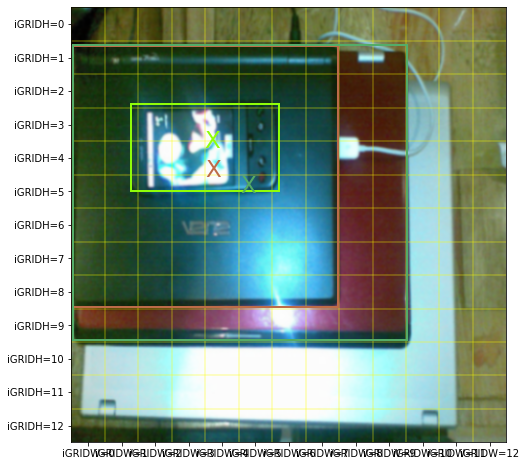

In [ ]:
iframe = 3
def plot_image_with_grid_cell_partition(irow):
    img = x_aug_batch[irow]
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    for wh in ["W","H"]:
        GRID_ = config["GRID_"  + wh] ## 13
        IMAGE_ = config["IMAGE_" + wh] ## 416
        if wh == "W":
            pltax   = plt.axvline
            plttick = plt.xticks
        else:
            pltax   = plt.axhline
            plttick = plt.yticks
            
        for count in range(GRID_):
            l = IMAGE_*count/GRID_
            pltax(l,color="yellow",alpha=0.3) 
        plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])

def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(config["GRID_H"]):
        for igrid_w in range(config["GRID_W"]):
            for ianchor in range(config["BOX"]):
                vec = y_aug_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                    class_nm = np.array(config['LABELS'])[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = config["IMAGE_W"]/config["GRID_W"]
                    multy = config["IMAGE_H"]/config["GRID_H"]
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5*w
                    ymin = y - 0.5*h
                    xmax = x + 0.5*w
                    ymax = y + 0.5*h
                    # center
                    plt.text(x*multx,y*multy,
                             "X",color=c,fontsize=23)
                    plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=2)
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=2)
                    plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=2)  
                    plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=2)

plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

# YOLOv2 model

Explore more

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda, LeakyReLU, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
import tensorflow as tf

In [ ]:
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

In [ ]:
input_image = Input(shape=(config['IMAGE_H'], config['IMAGE_W'], 3))
true_boxes  = Input(shape=(1, 1, 1, config['TRUE_BOX_BUFFER'] , 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2, 2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 23
x = Conv2D(config['BOX'] * (4 + 1 + len(config['LABELS'])), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((config['GRID_H'], config['GRID_W'], config['BOX'], 4 + 1 + len(config['LABELS'])))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, true_boxes])

model = Model([input_image, true_boxes], output)

In [ ]:
if False:
    !wget https://pjreddie.com/media/files/yolov2.weights

In [ ]:
#path_to_weight = '/content/drive/My Drive/Colab Notebooks/Object Detection/yolov2.weights'
path_to_weight = '/content/yolov2.weights'

In [ ]:
class WeightReader:
    # code from https://github.com/experiencor/keras-yolo2/blob/master/Yolo%20Step-by-Step.ipynb
    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def reset(self):
        self.offset = 4
                
#weight_reader = WeightReader(path_to_weight)
#print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

In [ ]:
def set_pretrained_weight(model,nb_conv, path_to_weight):
    weight_reader = WeightReader(path_to_weight)
    weight_reader.reset()
    for i in range(1, nb_conv+1):
        conv_layer = model.get_layer('conv_' + str(i)) ## convolusional layer

        if i < nb_conv:
            norm_layer = model.get_layer('norm_' + str(i)) ## batch normalization layer

            size = np.prod(norm_layer.get_weights()[0].shape)

            beta  = weight_reader.read_bytes(size)
            gamma = weight_reader.read_bytes(size)
            mean  = weight_reader.read_bytes(size)
            var   = weight_reader.read_bytes(size)

            weights = norm_layer.set_weights([gamma, beta, mean, var])       

        if len(conv_layer.get_weights()) > 1: ## with bias
            bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel, bias])
        else: ## without bias
            kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
            kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
            kernel = kernel.transpose([2,3,1,0])
            conv_layer.set_weights([kernel])
    return model

#nb_conv = 22
#model = set_pretrained_weight(model,nb_conv, path_to_weight)

In [ ]:
def initialize_weight(layer,sd):
    weights = layer.get_weights()
    new_kernel = np.random.normal(size=weights[0].shape, scale=sd)
    new_bias   = np.random.normal(size=weights[1].shape, scale=sd)
    layer.set_weights([new_kernel, new_bias])
    
#layer   = model.layers[-4] # the last convolutional layer
#initialize_weight(layer,sd=config['GRID_H']*config['GRID_W'])

### Visualize model

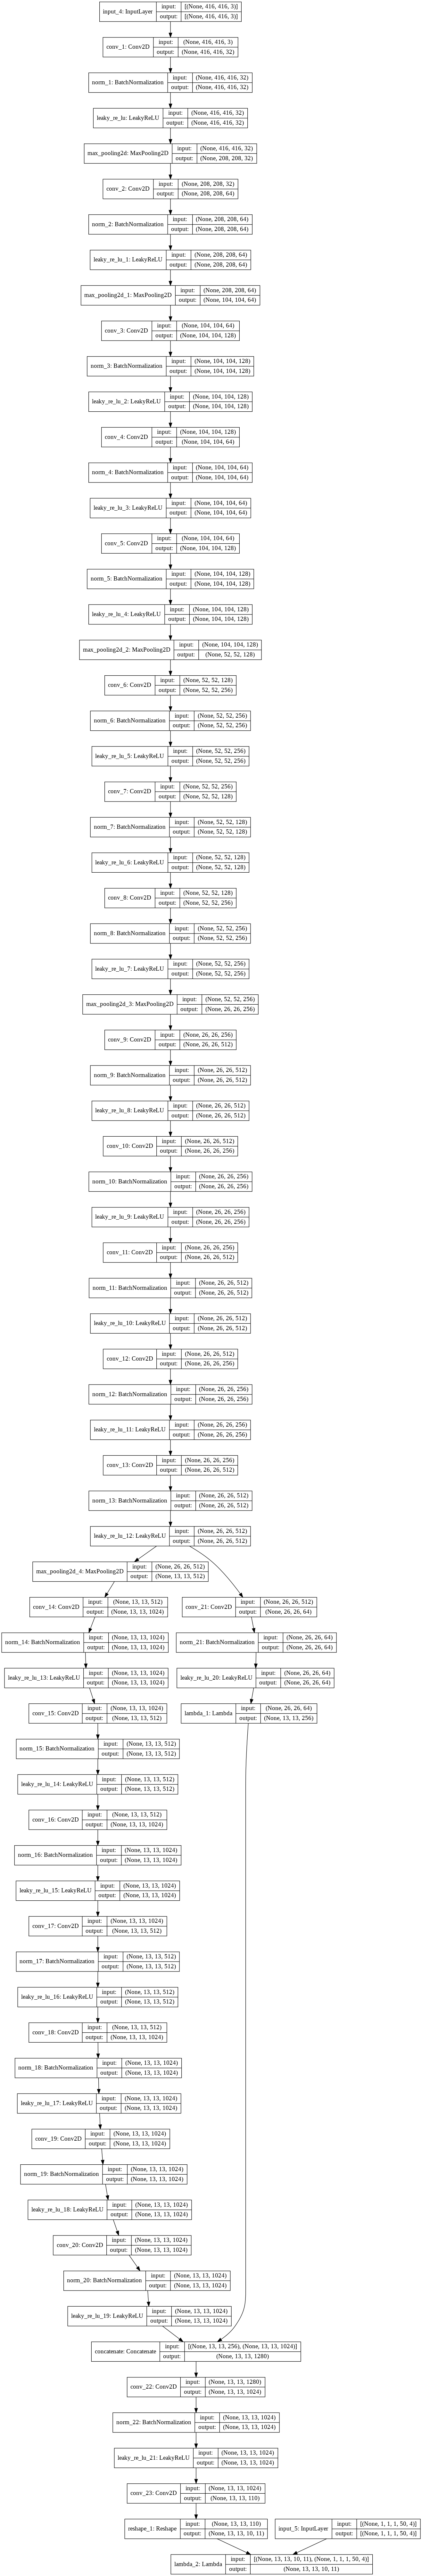

In [ ]:
plot_model(model, 'model.png', show_shapes=True, expand_nested=True)

# Loss Function

\begin{array}{rl}\small
\textrm{loss}_{i,j} &= \textrm{loss}_{i,j}^{xywh} +  \textrm{loss}_{i,j}^p + \textrm{loss}_{i,j}^c \\
%%%
\textrm{loss}_{i,j}^{xywh}&=
\frac{\lambda_{\textrm{coord}}}{N_{L^{obj}}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{obj}}
\big[
\left(x_{i,j}-\hat{x}_{i,j}\right)^2 + 
\left(y_{i,j}-\hat{y}_{i,j}\right)^2 +\\
&\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\left(\sqrt{w}_{i,j}-\sqrt{\hat{w}}_{i,j}\right)^2 +
\left(\sqrt{h}_{i,j}-\sqrt{\hat{h}}_{i,j}\right)^2 
\big]\\
%%%
\textrm{loss}_{i,j}^p&=
-\frac{\lambda_{\text{class}}}{N_{L^{obj}}}
\sum_{i=0}^{S^2} \sum_{j=0}^B L_{i,j}^{\text{obj}}
\sum_{c \in \text{class}}  p_{i,j}^c \text{log}(\hat{p}_{i,j}^c)\\
%%%
\textrm{loss}_{i,j}^c &=
\frac{\lambda_{\text{obj}}}{N^{conf}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{obj}}
\left(
IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i,j}} - \widehat{C}_{i,j}
\right)^2\\
&\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;+
\frac{\lambda_{\textrm{noobj}}}{N^{conf}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{noobj}}
\left(0 - \widehat{C}_{i,j}\right)\\
\end{array}

## Helper Functions and Variables

In [ ]:
LAMBDA_NO_OBJECT = config['LAMBDA_NO_OBJECT']
LAMBDA_OBJECT = config['LAMBDA_OBJECT']
LAMBDA_COORD = config['LAMBDA_COORD']
LAMBDA_CLASS = config['LAMBDA_CLASS']
GRID_W = config['GRID_W']
GRID_H = config['GRID_H'] 
BATCH_SIZE = config['BATCH_SIZE']
BOX = config['BOX']
CLASS = len(config['LABELS'])

In [ ]:
def get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX):
    # to ensure bounding box x and y are in grid scale output
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_H), [GRID_W]), (1,GRID_H, GRID_W, 1, 1)), tf.float32)
    cell_y = tf.transpose(cell_x, (0,2,1,3,4))
    cell_grid = tf.tile(tf.concat([cell_x, cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return cell_grid

In [ ]:
def adjust_scale_prediction(y_pred, cell_grid, ANCHORS):
    """
        Adjust prediction
        
        == input ==
        
        y_pred : takes any real values
                 tensor of shape = (N batch, NGrid h, NGrid w, NAnchor, 4 + 1 + N class)
        
        ANCHORS : list containing width and height specializaiton of anchor box
        == output ==
        
        pred_box_xy : shape = (N batch, N grid x, N grid y, N anchor, 2), containing [center_x, center_y] ranging [0,0]x[grid_H-1,grid_W-1]
          pred_box_xy[i_image,igrid_h,igrid_w,ianchor,0] =  center_x
          pred_box_xy[i_image,igrid_h,igrid_w,ianchor,1] =  center_y
          
          calculation process:
          tf.sigmoid(y_pred[...,:2]) : takes values between 0 and 1
          tf.sigmoid(y_pred[...,:2]) + cell_grid : takes values between 0 and grid_W - 1 for x coordinate 
                                                   takes values between 0 and grid_H - 1 for y coordinate 
                                                   
        pred_Box_wh : shape = (N batch, N grid h, N grid w, N anchor, 2), containing width and height, rangining [0,0]x[grid_H-1,grid_W-1]
        
        pred_box_conf : shape = (N batch, N grid h, N grid w, N anchor, 1), containing confidence to range between 0 and 1
        
        pred_box_class : shape = (N batch, N grid h, N grid w, N anchor, N class), containing 
    """
    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid
    pred_box_wh = tf.exp(y_pred[..., 2:4]) + np.reshape(ANCHORS, [1, 1, BOX, 2])
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    pred_box_class = y_pred[..., 5:]

    return (pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class)

In [ ]:
def print_min_max(vec, title):
    print(f"{title} MIN = {np.min(vec)}, MAX = {np.max(vec)}")

In [ ]:
if unit_testing:
    print('*' * 30)
    print('prepare inputs')
    size = BATCH_SIZE * GRID_H * GRID_W * BOX * (4 + 1 + CLASS)
    y_pred = np.random.normal(size = size, scale = 10/(GRID_W * GRID_H))
    y_pred = y_pred.reshape(BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + CLASS)
    print(f"y_pred before scaling = {y_pred.shape}")

    print('*' * 30)
    print('define tensor graph')
    y_pred_tf = tf.constant(y_pred, dtype="float32")
    cell_grid = get_cell_grid(GRID_W ,GRID_H, BATCH_SIZE, BOX)

    (pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class) = adjust_scale_prediction(y_pred_tf, cell_grid, anchors)

    print("*"*30 + "\nouput\n" + "*"*30) 

    print("\npred_box_xy {}".format(pred_box_xy.shape)) 

    for igrid_w in range(pred_box_xy.shape[2]):
            print_min_max(pred_box_xy[:,:,igrid_w,:,0],
                        "  bounding box x at iGRID_W={:02.0f}".format(igrid_w))
    for igrid_h in range(pred_box_xy.shape[1]):
        print_min_max(pred_box_xy[:,igrid_h,:,:,1],
                    "  bounding box y at iGRID_H={:02.0f}".format(igrid_h)) 
        
    print("\npred_box_wh {}".format(pred_box_wh.shape))
    print_min_max(pred_box_wh[:,:,:,:,0],"  bounding box width ") 
    print_min_max(pred_box_wh[:,:,:,:,1],"  bounding box height") 
        
    print("\npred_box_conf {}".format(pred_box_conf.shape))
    print_min_max(pred_box_conf,"  confidence ") 

    print("\npred_box_class {}".format(pred_box_class.shape))
    print_min_max(pred_box_class,"  class probability") 

******************************
prepare inputs
y_pred before scaling = (4, 13, 13, 10, 11)
******************************
define tensor graph
******************************
ouput
******************************

pred_box_xy (4, 13, 13, 10, 2)
  bounding box x at iGRID_W=00 MIN = 0.452700138092041, MAX = 0.549953818321228
  bounding box x at iGRID_W=01 MIN = 1.4587572813034058, MAX = 1.541583776473999
  bounding box x at iGRID_W=02 MIN = 2.454362154006958, MAX = 2.546187400817871
  bounding box x at iGRID_W=03 MIN = 3.4526233673095703, MAX = 3.5441808700561523
  bounding box x at iGRID_W=04 MIN = 4.453769683837891, MAX = 4.5433430671691895
  bounding box x at iGRID_W=05 MIN = 5.45456075668335, MAX = 5.552667140960693
  bounding box x at iGRID_W=06 MIN = 6.462880611419678, MAX = 6.551304817199707
  bounding box x at iGRID_W=07 MIN = 7.454916954040527, MAX = 7.546473026275635
  bounding box x at iGRID_W=08 MIN = 8.454663276672363, MAX = 8.548254013061523
  bounding box x at iGRID_W=09 MIN =

In [ ]:
def extract_ground_truth(y_true):
    true_box_xy = y_true[..., 0:2]
    true_box_wh = y_true[..., 2:4]
    true_box_conf = y_true[..., 4]
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return true_box_xy, true_box_wh, true_box_conf, true_box_class

In [ ]:
y_batch_tf = tf.constant(y_batch,dtype="float32")
(true_box_xy, true_box_wh, true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)

## loss_xywh

\begin{array}{rl}
\textrm{loss}_{i,j}^{xywh}&=
\frac{1}{N_{L^{obj}}}
\lambda_{\textrm{coord}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{obj}}
\big[
\left(x_{i,j}-\hat{x}_{i,j}\right)^2 + 
\left(y_{i,j}-\hat{y}_{i,j}\right)^2 +\\
&\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\left(\sqrt{w}_{i,j}-\sqrt{\hat{w}}_{i,j}\right)^2 +
\left(\sqrt{h}_{i,j}-\sqrt{\hat{h}}_{i,j}\right)^2 
\big]
\end{array}

In [ ]:
def calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh):
    coord_mask = tf.expand_dims(true_box_conf, axis = -1) * LAMBDA_COORD
    nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))
    #print(nb_coord_box)
    loss_xy = tf.reduce_sum(tf.square(true_box_xy - pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh - pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.
    
    return (loss_xy + loss_wh, coord_mask)

In [ ]:
loss_xywh, coord_mask = calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh)
print(f'loss_xywh = {loss_xywh}')
coord_mask.shape

loss_xywh = 1.4250385761260986


TensorShape([4, 13, 13, 10, 1])

## loss_class

\begin{array}{rl}
\textrm{loss}_{i,j}^p=-\frac{1}{N_{L^{obj}}}
\lambda_{\text{class}}\sum_{i=0}^{S^2} \sum_{j=0}^B L_{i,j}^{\text{obj}}
\sum_{c \in \text{class}}  p_{i,j}^c \text{log}(\hat{p}_{i,j}^c)
\end{array}

In [ ]:
def calc_loss_class(true_box_conf, LAMBDA_CLASS, true_box_class, pred_box_class):
    class_mask = true_box_conf * LAMBDA_CLASS
    nb_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(labels = true_box_class, logits = pred_box_class)
    loss_class = tf.reduce_sum(loss_class * class_mask) / (nb_class_box + 1e-6)
    return loss_class

In [ ]:
loss_class = calc_loss_class(true_box_conf, LAMBDA_CLASS, true_box_class, pred_box_class)
print(f'loss_class = {loss_class:4.3f}')

loss_class = 1.810


## loss_confidence

\begin{array}{rl}
\textrm{loss}_{i,j}^c =\lambda_{\text{obj}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{obj}}
\left(
IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i,j}} - \widehat{C}_{i,j}
\right)^2+
\lambda_{\textrm{noobj}}
\sum_{i=0}^{S^2}
\sum_{j=0}^B
L_{i,j}^{\text{noobj}}
\left(0 - \widehat{C}_{i,j}\right)
\end{array}

### Calculate IOU for loss

In [ ]:
def get_intersect_area(true_xy, true_wh, pred_xy, pred_wh):
    """
    == INPUT ==
    true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                 p1______________________ 
                 |      t1___________   |
                 |       |           |  |
                 |_______|___________|__|p2 
                         |           |rmax
                         |___________|
                                      t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)
    """
    true_wh_half = true_wh/2.
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half

    pred_wh_half = pred_wh/2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half

    intersect_mins = tf.maximum(pred_mins, true_mins)
    intersect_maxs = tf.minimum(pred_maxes, true_maxes)
    intersect_wh = tf.maximum(intersect_maxs - intersect_mins, 0)
    intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_areas = true_wh[..., 0] * true_wh[..., 1] 
    pred_areas = pred_wh[..., 0] * pred_wh[..., 1] 

    union_areas = pred_areas + true_areas - intersect_areas
    iou_scores = tf.divide(intersect_areas, union_areas)
    return iou_scores

In [ ]:
def calc_IOU_pred_true_assigned(true_box_conf, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh):
    ''' 
    == input ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor )
    true_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    true_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_xy   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
    pred_box_wh   : tensor of shape (N batch, N grid h, N grid w, N anchor , 2)
        
    == output ==
    
    true_box_conf : tensor of shape (N batch, N grid h, N grid w, N anchor)
    
    true_box_conf value depends on the predicted values 
    true_box_conf = IOU_{true,pred} if object exist in this anchor else 0
    '''
    iou_scores = get_intersect_area(true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
    true_box_conf_IOU = iou_scores * true_box_conf
    return true_box_conf_IOU

true_box_conf_IOU.shape = (4, 13, 13, 10)


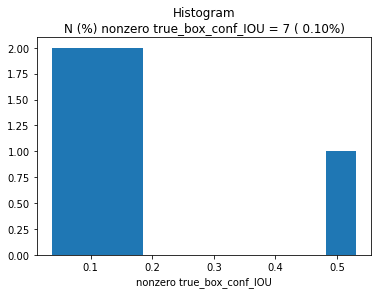

In [ ]:
if unit_testing:
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)

    print("true_box_conf_IOU.shape = {}".format(true_box_conf_IOU.shape))
    vec  = true_box_conf_IOU
    pick = vec!=0
    vec  = vec[pick]
    plt.hist(vec)
    plt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(np.sum(pick),
                                                                100*np.mean(pick)))
    plt.xlabel("nonzero true_box_conf_IOU")
    plt.show()

In [ ]:
def calc_IOU_pred_true_best(pred_box_xy, pred_box_wh, true_boxes):
    '''
    == input ==
    pred_box_xy : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    pred_box_wh : tensor of shape (N batch, N grid h, N grid w, N anchor, 2)
    true_boxes  : tensor of shape (N batch, N grid h, N grid w, N anchor, 4)
    
    == output == 
    
    best_ious
    
    for each image,
        best_ious[i_image,igridy,igridx,ianchor] contains
        
        the IOU of the object that is most likely included (or best fitted) 
        within the bounded box recorded in (grid_cell, anchor) pair
        
        NOTE: a same object may be contained in multiple (grid_cell, anchor) pair
              from best_ious, you cannot tell how may actual objects are captured as the "best" object
    '''
    true_xy = true_boxes[..., :2]
    true_wh = true_boxes[..., 2:4]

    pred_xy = tf.expand_dims(pred_box_xy, 4)
    pred_wh = tf.expand_dims(pred_box_wh, 4)

    iou_scores = get_intersect_area(true_xy, true_wh, pred_xy, pred_wh)
    best_ious = tf.reduce_max(iou_scores, axis = 4)
    return best_ious

best_ious.shape = (4, 13, 13, 10)


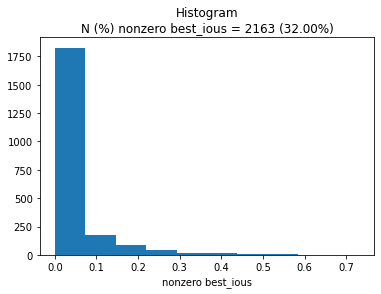

In [ ]:
if unit_testing:
    true_boxes = tf.constant(b_batch,dtype="float32")
    best_ious = calc_IOU_pred_true_best(pred_box_xy, pred_box_wh, true_boxes)

    print("best_ious.shape = {}".format(best_ious.shape))
    vec  = best_ious
    pick = vec!=0
    vec  = vec[pick]
    plt.hist(vec)
    plt.title("Histogram\nN (%) nonzero best_ious = {} ({:5.2f}%)".format(np.sum(pick),
                                                                100*np.mean(pick)))
    plt.xlabel("nonzero best_ious")
    plt.show()

### noobj loss

\begin{array}{rl}
L_{i,j}^{\text{noobj}}
& = 
\begin{cases}
 1 \;\;\text{if}\;\;\text{max}_{i',j'}
 \;\;IOU_{\text{preduiction}_{i,j}}^{\text{ground truth}_{i',j'}} < 0.6 \;\text{and}\; C_{i,j} = 0\\
 0\;\;\text{else}\\
\end{cases}
\end{array}

In [ ]:
def get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU, LAMBDA_NO_OBJECT, LAMBDA_OBJECT):
    '''
    == input == 
    
    best_ious           : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf       : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    true_box_conf_IOU   : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    LAMBDA_NO_OBJECT    : 1.0
    LAMBDA_OBJECT       : 5.0
    
    == output ==
    conf_mask : tensor of shape (Nbatch, N grid h, N grid w, N anchor)
    
    conf_mask[i_image, igridy, igridx, ianchor] = 0
               when there is no object assigned in (grid cell, anchor) pair and the region seems useless i.e. 
               y_true[i_image,igridx,igridy,4] = 0 "and" the predicted region has no object that has IoU > 0.6
               
    conf_mask[i_image, igridy, igridx, ianchor] =  NO_OBJECT_SCALE
               when there is no object assigned in (grid cell, anchor) pair but region seems to include some object
               y_true[i_image,igridx,igridy,4] = 0 "and" the predicted region has some object that has IoU > 0.6
               
    conf_mask[i_image, igridy, igridx, ianchor] =  OBJECT_SCALE
              when there is an object in (grid cell, anchor) pair        
    '''

    conf_mask = tf.cast(best_ious < 0.6, tf.float32) * (1 - true_box_conf) * LAMBDA_NO_OBJECT
    conf_mask = conf_mask + true_box_conf_IOU * LAMBDA_OBJECT
    return conf_mask

In [ ]:
conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU,LAMBDA_NO_OBJECT, LAMBDA_OBJECT)

### Calculate confidence loss

In [ ]:
def calc_loss_conf(conf_mask, true_box_conf_IOU, pred_box_conf):
    nb_conf_box = tf.reduce_sum(tf.cast(conf_mask > 0.0, tf.float32))
    loss_conf = tf.reduce_sum(tf.square(true_box_conf_IOU - pred_box_conf) * conf_mask) / (nb_conf_box + 1e-6)/2.
    return loss_conf

In [ ]:
loss_conf = calc_loss_conf(conf_mask,true_box_conf_IOU, pred_box_conf)
print("loss_conf = {:5.4f}".format(loss_conf))

loss_conf = 0.1250


## Combining all losses to make a custom loss function

In [ ]:
def custom_loss(y_true, y_pred):
    '''
    y_true : (N batch, N grid h, N grid w, N anchor, 4 + 1 + N classes)
    y_true[irow, i_gridh, i_gridw, i_anchor, :4] = center_x, center_y, w, h
    y_true[irow, i_gridh, i_gridw, i_anchor, 4] = ground truth confidence
    y_true[irow, i_gridh, i_gridw, i_anchor, 5 + iclass] = 1 if the object is in category  else 0      
    ''' 
    total_recall = tf.Variable(0.)

    # Step 1: Adjust prediction output
    cell_grid = get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX)
    pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class = adjust_scale_prediction(y_pred, cell_grid, anchors)

    # Step 2: Extract ground truth output
    true_box_xy, true_box_wh, true_box_conf, true_box_class = extract_ground_truth(y_true)

    # Step 3: Calculate loss for the bounding box parameters
    loss_xywh, coord_mask = calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh)

    # Step 4: Calculate loss for class probabilities
    loss_class = calc_loss_class(true_box_conf, LAMBDA_CLASS, true_box_class, pred_box_class)

    # Step 5: For each (grid_cell, anchor) pair, calculate IOU between predicted and ground truth bounding box
    true_box_conf_IOU = calc_IOU_pred_true_assigned(true_box_conf, true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)

    # Step 6: For each predicted bounding box from (grid cell, anchor box) pair, calculate the best IOU, 
    # regardless for the ground truth anchor box the each object gets assigned
    best_ious = calc_IOU_pred_true_best(pred_box_xy, pred_box_wh, true_boxes)

    # Step 7: For each grid cell ,calculate the noobj probabilites
    conf_mask = get_conf_mask(best_ious, true_box_conf, true_box_conf_IOU, LAMBDA_NO_OBJECT, LAMBDA_OBJECT)

    # Step 8: Calculate loss for the confidence
    loss_conf = calc_loss_conf(conf_mask, true_box_conf_IOU, pred_box_conf)

    loss = loss_xywh + loss_class + loss_conf
    return loss

In [ ]:
print(y_batch.dtype, y_pred.dtype)
true_boxes = tf.Variable(np.zeros_like(b_batch), dtype="float32")
loss = custom_loss(y_batch.astype('float32'), y_pred.astype('float32')) 
print('loss', loss)

float64 float64
loss tf.Tensor(3.3595533, shape=(), dtype=float32)


# Training the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [ ]:
dir_log = 'log/'
try:
    os.makedirs(dir_log)
except:
    pass

In [ ]:
weights_path = '/content/drive/MyDrive/Colab Notebooks/Object Detection/Models/weights_yolo_on_coco_furniture_2019_v2_1.185.h5'
#model.load_weights(weights_path)

In [ ]:
print(config['BATCH_SIZE'])
es = EarlyStopping(monitor='val_loss', min_delta=0.01, patience = 5, verbose = 1, restore_best_weights = False)
mc = ModelCheckpoint(weights_path, monitor='val_loss', verbose=1, save_best_only=True)
rlr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.5, min_delta = 0.1, patience = 3, verbose = 1)
opt = Adam(learning_rate=1e-7, beta_1=0.9, beta_2=0.9)

model.compile(loss = custom_loss, optimizer=opt)

4


In [ ]:
tf.config.run_functions_eagerly(True)

train_batch_generator = SimpleBatchGenerator(train_dataset, train_image_instances_idxes, config, normalize_img, shuffle=False)
val_batch_generator = SimpleBatchGenerator(val_dataset, val_image_instances_idxes, config, normalize_img, shuffle = False)
train_batch_generator_with_aug = SimpleBatchGeneratorWithAug(train_dataset, train_image_instances_idxes, config, Image_aug, aug, normalize_img, shuffle = False)

history = model.fit(train_batch_generator, 
          steps_per_epoch = len(train_batch_generator),
          epochs = 20,
          verbose = 1, 
          callbacks = [es, mc, rlr],
          validation_data = val_batch_generator
          )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/20
809/809 [==============================] - 231s 286ms/step - loss: 0.6619 - val_loss: 1.1950

Epoch 00001: val_loss improved from inf to 1.19495, saving model to /content/drive/MyDrive/Colab Notebooks/Object Detection/Models/weights_yolo_on_coco_furniture_2019_v2_1.185.h5
Epoch 2/20
809/809 [==============================] - 234s 290ms/step - loss: 0.5817 - val_loss: 1.1981

Epoch 00002: val_loss did not improve from 1.19495
Epoch 3/20
809/809 [==============================] - 231s 286ms/step - loss: 0.5728 - val_loss: 1.1723

Epoch 00003: val_loss improved from 1.19495 to 1.17229, saving model to /content/drive/MyDrive/Colab Notebooks/Object Detection/Models/weights_yolo_on_coco_furniture_2019_v2_1.185.h5
Epoch 4/20
809/809 [==============================] - 239s 295ms/step - loss: 0.5654 - val_loss: 1.1717

Epoch 00004: val_loss improved from 1.17229 to 1.17168, saving model to /content/drive/MyDrive/Colab Notebooks/Object Detection/Models/weights_yolo_on_coco_furniture_2

# Evaluation

Evaluation shows that YOLOv2 architecture does not have the complexity required to get an acceptable result on MS-COCO dataset

In [ ]:
weights_path = '/content/drive/My Drive/Colab Notebooks/Object Detection/weights_yolo_on_coco2019.h5'
model.load_weights(weights_path)

In [ ]:
opt = Adam(learning_rate=0.5e-5, beta_1=0.9, beta_2=0.9)
tf.config.run_functions_eagerly(True)
val_batch_generator = SimpleBatchGenerator(val_dataset, val_image_instances_idxes, config, normalize_img, shuffle = False)

model.compile(loss = custom_loss, optimizer=opt)
model.evaluate(val_batch_generator, verbose = 1)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


38/38 [==============================] - 8s 205ms/step - loss: 1.1481


1.1481319665908813

## performing detection on an image

In [ ]:
imageReader = ImageReader(config['IMAGE_H'], config['IMAGE_W'], norm=normalize_img)
out = imageReader.fit(train_dataset[train_image_instances_idxes[1]])

In [ ]:
print(out[0].shape)

X_test = np.expand_dims(out[0],0)
print(X_test.shape)

# handle the hack input
dummy_array = np.zeros((1,1,1,1,config['TRUE_BOX_BUFFER'],4))
y_pred = model.predict([X_test,dummy_array])
print(y_pred.shape)

(416, 416, 3)
(1, 416, 416, 3)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


(1, 13, 13, 10, 11)


In [ ]:
class OutputRescaler(object):
    def __init__(self, anchors):
        self.ANCHORS = anchors
    
    def sigmoid(self, x):
        return 1. / (1. + np.exp(-x))
    
    def softmax(self, x, axis = -1, t = -100.):
        x = x - np.max(x)
        if np.min(x) < t:
            x = x/np.min(x)*t

        e_x = np.exp(x)
        return e_x / e_x.sum(axis, keepdims = True)
    
    def get_shifting_matrix(self, netout):
        
        GRID_H, GRID_W, BOX = netout.shape[:3]
        no = netout[..., 0]
        ANCHORSw = self.ANCHORS[:, 0]
        ANCHORSh = self.ANCHORS[:, 1]
        
        mat_GRID_W = np.zeros_like(no)
        for igrid_w in range(GRID_W):
            mat_GRID_W[:, igrid_w, :] = igrid_w
        
        mat_GRID_H = np.zeros_like(no)
        for igrid_h in range(GRID_H):
            mat_GRID_H[igrid_h,:,:] = igrid_h

        mat_ANCHOR_W = np.zeros_like(no)
        for ianchor in range(BOX):    
            mat_ANCHOR_W[:,:,ianchor] = ANCHORSw[ianchor]

        mat_ANCHOR_H = np.zeros_like(no) 
        for ianchor in range(BOX):    
            mat_ANCHOR_H[:,:,ianchor] = ANCHORSh[ianchor]

        return mat_GRID_W,mat_GRID_H,mat_ANCHOR_W,mat_ANCHOR_H

    def fit(self, netout):    
        '''
        netout  : np.array of shape (N grid h, N grid w, N anchor, 4 + 1 + N class)
        
        a single image output of model.predict()
        '''
        GRID_H, GRID_W, BOX = netout.shape[:3]
        
        (mat_GRID_W, mat_GRID_H, mat_ANCHOR_W, mat_ANCHOR_H) = self.get_shifting_matrix(netout)


        # bounding box parameters
        netout[..., 0]   = (self.sigmoid(netout[..., 0]) + mat_GRID_W)/GRID_W # x      unit: range between 0 and 1
        netout[..., 1]   = (self.sigmoid(netout[..., 1]) + mat_GRID_H)/GRID_H # y      unit: range between 0 and 1
        netout[..., 2]   = (np.exp(netout[..., 2]) * mat_ANCHOR_W)/GRID_W      # width  unit: range between 0 and 1
        netout[..., 3]   = (np.exp(netout[..., 3]) * mat_ANCHOR_H)/GRID_H      # height unit: range between 0 and 1
        # rescale the confidence to range 0 and 1 
        netout[..., 4]   = self.sigmoid(netout[..., 4])
        expand_conf      = np.expand_dims(netout[...,4],-1) # (N grid h , N grid w, N anchor , 1)
        # rescale the class probability to range between 0 and 1
        # Pr(object class = k) = Pr(object exists) * Pr(object class = k |object exists)
        #                      = Conf * P^c
        netout[..., 5:]  = expand_conf * self.softmax(netout[..., 5:])
        # ignore the class probability if it is less than obj_threshold 
    
        return netout

In [ ]:
netout = y_pred[0]
outputRescaler = OutputRescaler(anchors=config['ANCHORS'])
netout_scale = outputRescaler.fit(netout)

In [ ]:
def find_high_class_probability_bbox(netout_scale, obj_threshold):
    '''
    == Input == 
    netout : y_pred[i] np.array of shape (GRID_H, GRID_W, BOX, 4 + 1 + N class)
    
             x, w must be a unit of image width
             y, h must be a unit of image height
             c must be in between 0 and 1
             p^c must be in between 0 and 1
    
    == Output ==
    boxes  : list containing bounding box with Pr(object is in class C) > obj_threshold for at least in one class C    
    '''
    GRID_H, GRID_W, BOX = netout_scale.shape[:3]
    
    boxes = []
    for row in range(GRID_H):
        for col in range(GRID_W):
            for b in range(BOX):
                # from 4th element onwards are confidence and class classes
                classes = netout_scale[row,col,b,5:]
                
                if np.sum(classes) > 0:
                    # first 4 elements are x, y, w, and h
                    x, y, w, h = netout_scale[row,col,b,:4]
                    confidence = netout_scale[row,col,b,4]
                    box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
                    if box.get_score() > obj_threshold:
                        boxes.append(box)
    return boxes

In [ ]:
obj_threshold = 0.03
boxes_tiny_threshold = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("obj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes_tiny_threshold),obj_threshold))

obj_threshold = 0.005
boxes = find_high_class_probability_bbox(netout_scale,obj_threshold)
print("\nobj_threshold={}".format(obj_threshold))
print("In total, YOLO can produce GRID_H * GRID_W * BOX = {} bounding boxes ".format( GRID_H * GRID_W * BOX))
print("I found {} bounding boxes with top class probability > {}".format(len(boxes),obj_threshold))

obj_threshold=0.03
In total, YOLO can produce GRID_H * GRID_W * BOX = 1690 bounding boxes 
I found 0 bounding boxes with top class probability > 0.03

obj_threshold=0.005
In total, YOLO can produce GRID_H * GRID_W * BOX = 1690 bounding boxes 
I found 1 bounding boxes with top class probability > 0.005


### Function to draw bounding boxes on images

Plot with low object threshold


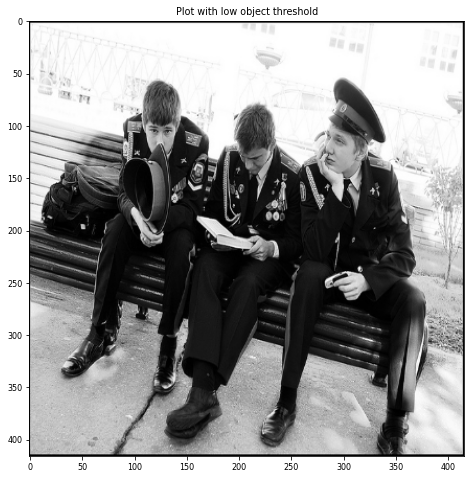

Plot with high object threshold
chair      0.007 xmin= 161,ymin=  15,xmax= 179,ymax=  21


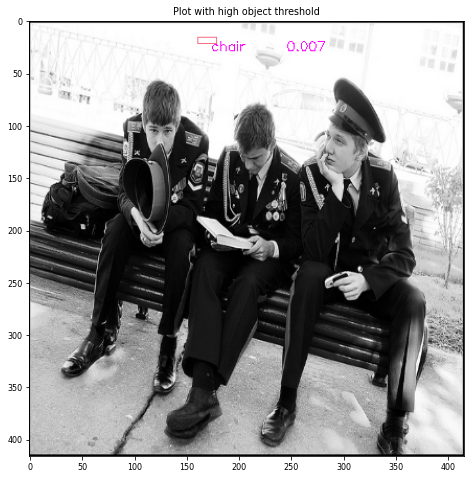

In [ ]:
import cv2, copy
import seaborn as sns

def draw_boxes(image, boxes, labels, obj_baseline=0.05,verbose=False):
    '''
    image : np.array of shape (N height, N width, 3)
    '''
    def adjust_minmax(c,_max):
        if c < 0:
            c = 0   
        if c > _max:
            c = _max
        return c
    
    image = copy.deepcopy(image)
    image_h, image_w, _ = image.shape
    score_rescaled  = np.array([box.get_score() for box in boxes])
    score_rescaled /= obj_baseline
    
    colors = sns.color_palette("husl", 8)
    for sr, box,color in zip(score_rescaled,boxes, colors):
        xmin = adjust_minmax(int(box.xmin*image_w),image_w)
        ymin = adjust_minmax(int(box.ymin*image_h),image_h)
        xmax = adjust_minmax(int(box.xmax*image_w),image_w)
        ymax = adjust_minmax(int(box.ymax*image_h),image_h)
 
        
        text = "{:10} {:4.3f}".format(labels[box.label], box.get_score())
        if verbose:
            print("{} xmin={:4.0f},ymin={:4.0f},xmax={:4.0f},ymax={:4.0f}".format(text,xmin,ymin,xmax,ymax,text))
        cv2.rectangle(image, 
                      pt1=(xmin,ymin), 
                      pt2=(xmax,ymax), 
                      color=color, 
                      thickness=sr)
        cv2.putText(img       = image, 
                    text      = text, 
                    org       = (xmin+ 13, ymin + 13),
                    fontFace  = cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale = 1e-3 * image_h,
                    color     = (1, 0, 1),
                    thickness = 1)
        
    return image


print("Plot with low object threshold")
ima = draw_boxes(X_test[0],boxes_tiny_threshold,config['LABELS'],verbose=True)
figsize = (8,8)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with low object threshold")
plt.show()

print("Plot with high object threshold")
ima = draw_boxes(X_test[0],boxes,config['LABELS'],verbose=True)
figsize = (8,8)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.title("Plot with high object threshold")
plt.show()

In [ ]:
def nonmax_suppression(boxes,iou_threshold,obj_threshold):
    '''
    boxes : list containing "good" BoundBox of a frame
            [BoundBox(),BoundBox(),...]
    '''
    bestAnchorBoxFinder    = BestAnchorBoxFinder([])
    
    CLASS = len(boxes[0].classes)
    index_boxes = []   
    # suppress non-maximal boxes
    for c in range(CLASS):
        # extract class probabilities of the c^th class from multiple bbox
        class_probability_from_bbxs = [box.classes[c] for box in boxes]

        #sorted_indices[i] contains the i^th largest class probabilities
        sorted_indices = list(reversed(np.argsort( class_probability_from_bbxs)))

        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            
            # if class probability is zero then ignore
            if boxes[index_i].classes[c] == 0:  
                continue
            else:
                index_boxes.append(index_i)
                for j in range(i+1, len(sorted_indices)):
                    index_j = sorted_indices[j]
                    
                    # check if the selected i^th bounding box has high IOU with any of the remaining bbox
                    # if so, the remaining bbox' class probabilities are set to 0.
                    bbox_iou = bestAnchorBoxFinder.bbox_iou(boxes[index_i], boxes[index_j])
                    if bbox_iou >= iou_threshold:
                        classes = boxes[index_j].classes
                        classes[c] = 0
                        boxes[index_j].set_class(classes)
                        
    newboxes = [ boxes[i] for i in index_boxes if boxes[i].get_score() > obj_threshold ]                
    
    return newboxes

In [ ]:
iou_threshold = 0.01
final_boxes = nonmax_suppression(boxes,iou_threshold=iou_threshold,obj_threshold=obj_threshold)
print("{} final number of boxes".format(len(final_boxes)))

6 final number of boxes


chair      0.007 xmin= 161,ymin=  15,xmax= 179,ymax=  21
chair      0.007 xmin= 161,ymin=  15,xmax= 179,ymax=  21
chair      0.007 xmin= 161,ymin=  15,xmax= 179,ymax=  21
chair      0.007 xmin= 161,ymin=  15,xmax= 179,ymax=  21
chair      0.007 xmin= 161,ymin=  15,xmax= 179,ymax=  21
chair      0.007 xmin= 161,ymin=  15,xmax= 179,ymax=  21


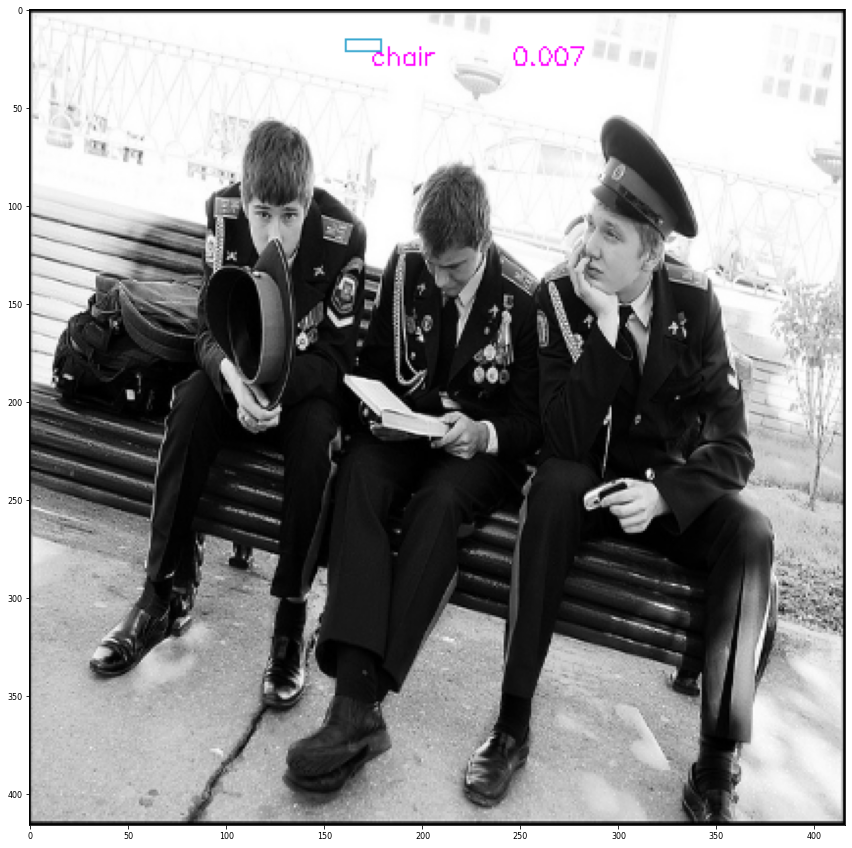

In [ ]:
ima = draw_boxes(X_test[0],final_boxes,config['LABELS'],verbose=True)
figsize = (15,15)
plt.figure(figsize=figsize)
plt.imshow(ima); 
plt.show()

In [ ]:
np.random.seed(1)
Nsample   = 20
image_nms = list(np.random.choice(val_image_instances_idxes, Nsample))

In [ ]:
outputRescaler = OutputRescaler(anchors=config['ANCHORS'])
imageReader = ImageReader(config['IMAGE_H'], config['IMAGE_W'], norm=normalize_img)
X_test = []
for img_nm in image_nms:
    val_instance = val_dataset[img_nm]
    out = imageReader.fit(val_instance)[0]
    X_test.append(out)

X_test = np.array(X_test)

## model
dummy_array    = np.zeros((len(X_test),1,1,1,config['TRUE_BOX_BUFFER'],4))
y_pred         = model.predict([X_test,dummy_array])

for iframe in range(len(y_pred)):
        netout         = y_pred[iframe] 
        netout_scale   = outputRescaler.fit(netout)
        boxes          = find_high_class_probability_bbox(netout_scale,obj_threshold)
        if len(boxes) > 0:
            final_boxes    = nonmax_suppression(boxes,
                                                iou_threshold=iou_threshold,
                                                obj_threshold=obj_threshold)
            ima = draw_boxes(X_test[iframe],final_boxes, config['LABELS'],verbose=True)
            plt.figure(figsize=figsize)
            plt.imshow(ima); 
            plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "
